#Homework 5: Confusion Matrix. ROC. AUC.

# Part 1
You will predict for an insuarance company how likely the person will be admitted to a hospital within the next year `DaysInHospital_Y2.csv`. The following data is provided: paitients' information `Members.csv` (age, sex) medical services provided in the previous year `Claims_Y1.csv` (provider, doctor, illness, days in hospital, etc. ).
Data source: https://www.kaggle.com/competitions/hhp/overview

You can dounload files directly from https://github.com/truongkhanhduy95/Heritage-Health-Prize/tree/master/data (click *Raw data* and copy the path). **If you use this repo, use 'Claims.csv' instead of 'Claims_Y1.csv'**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. (1pt) Read the data using parameter index_col = `MemberID`.

* table 'DaysInHospital_Y2.csv' into variable `days2`
* table 'Members.csv' into variable `m`
* table 'Claims_Y1.csv' into variable `claims`

In [2]:
path = 'https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/'

In [3]:
m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [4]:
claims=pd.read_csv(path+'Claims.csv',index_col='MemberID')
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [5]:
days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


To anonymize the data, the organizer provided approximate information about patients, for example, in the Age column, age groups are specified: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. We will convert string features into numerical ones and replace missing values.

In [6]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

<ipython-input-6-a189b6f0acbb>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


Let's construct features based on the array of medical service cases:
* `f_Charlson` — the maximum Charlson comorbidity index among all cases for the patient (`CharlsonIndex` in the table `claims`)
* `f_LengthOfStay` —  the total number of hospitalization days in the past year  (`LengthOfStay` in the table `claims`)


In [7]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

We will create a feature matrix with the following columns: `f_Charlson`, `f_LengthOfStay`, `AgeAtFirstClaim`, `ClaimsTruncated` (whether there were too many medical service cases).

In [8]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


## 2. (3pt) Add to the features columm `Sex`

In [9]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


## 3. (1pt) Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.5, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42)

##4. (2pt) The column `Sex` contains missing values. Create the column transformer that will apply One-Hot-Encoder to this column with parameter `handle_unknown='infrequent_if_exist'`. It will create automatically `'OneHot__Sex_nan'` column afer fitting this transformer on the Train set. (Don't forget parameter `reminder`)

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
ct = ColumnTransformer(
    [('OneHot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Sex'])],
    remainder='passthrough'
)

ct.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

## 5. (3pt) Create a pipeline for training logistic regression. It should include transformation, scaling, and model. And fit it on the Training set

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [15]:

pipe = Pipeline([
    ('transformer', ct),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(solver='liblinear'))
])

pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex'])])),
                ('scaler', MinMaxScaler()),
                ('model', LogisticRegression(solver='liblinear'))])

## 6. (2pt) Plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay

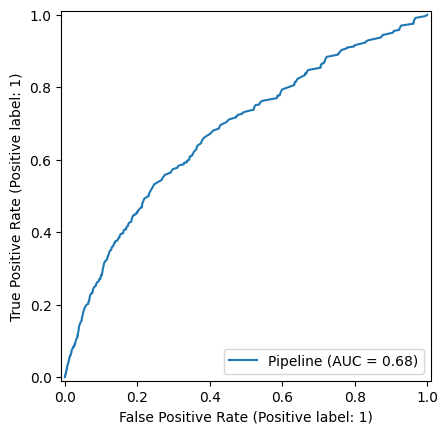

In [17]:
y_pred = pipe.predict(X_valid)
RocCurveDisplay.from_estimator(pipe, X_valid, y_valid)
plt.show()

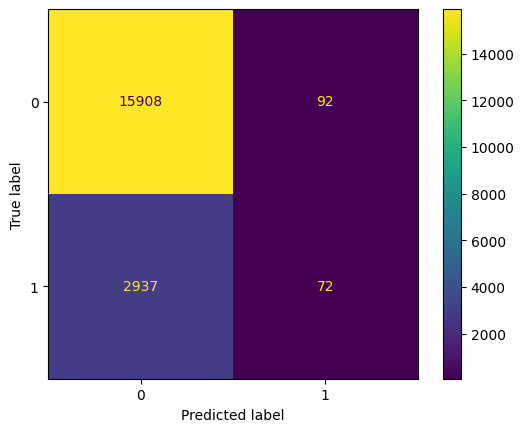

In [18]:
ConfusionMatrixDisplay.from_estimator(pipe, X_valid, y_valid)
plt.show()

In [19]:
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall}")

Recall: 0.023928215353938187


## 7. (4pt) Use `.predict_proba` to get the values in the interval $[0,\ 1]$ instead of the classes 0 or 1.

Choose the threshold, such that recall on the Validation set is $>0.5$ (Think about this as the insuarance company's requirement.)

For the chosen threshold plot ROC-AUC (it won't change because the model stays unchanged) and Confusion Matrix. Report the Recall value.

In [26]:
# Get predicted probabilities
y_prob = pipe.predict_proba(X_valid)[:, 1]

# Find optimal threshold for recall > 0.5
thresholds = np.linspace(0, 1, 101)
best_threshold = 0
best_recall = 0

In [27]:
for threshold in thresholds:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    recall = recall_score(y_valid, y_pred_thresh)
    if recall > 0.5 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Recall: {best_recall}")

Best Threshold: 0.0, Recall: 1.0


In [28]:
y_pred_best = (y_prob >= best_threshold).astype(int)

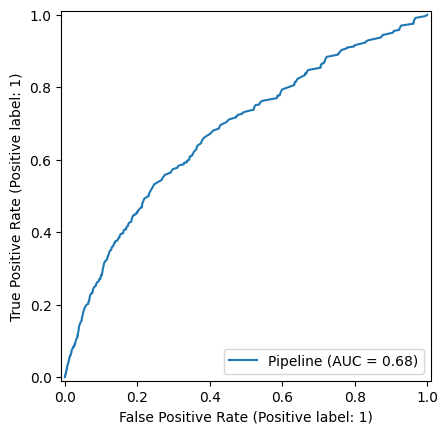

In [29]:
RocCurveDisplay.from_estimator(pipe, X_valid, y_valid)
plt.show()

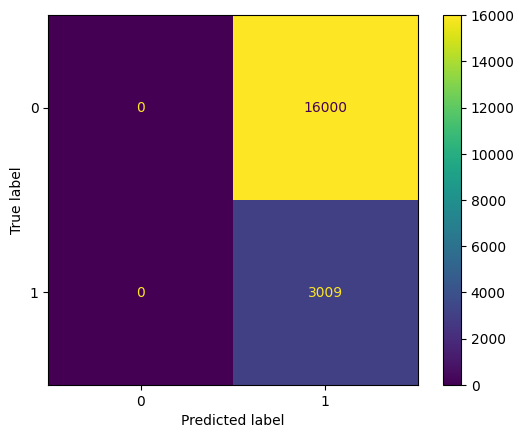

In [30]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_best)
plt.show()

In [31]:
recall_best = recall_score(y_valid, y_pred_best)
print(f"Recall with chosen threshold: {recall_best}")

Recall with chosen threshold: 1.0


## 8. (2 pt) Finally, plot ROC-AUC and Confusion Matrix, and report the Recall value on the Test set.

In [32]:
y_pred_test = pipe.predict(X_test)

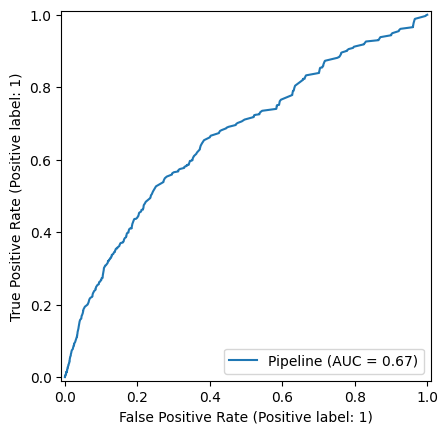

In [33]:
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

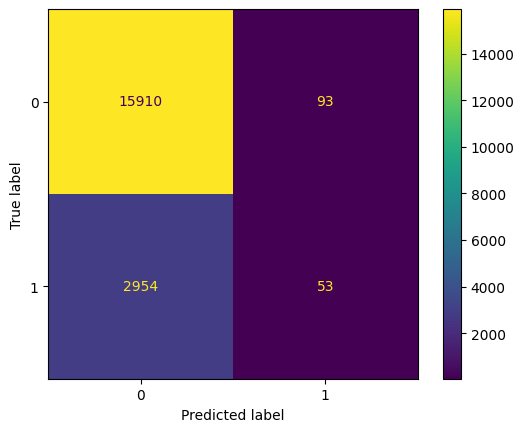

In [34]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

In [35]:
recall_test = recall_score(y_test, y_pred_test)
print(f"Recall on Test Set: {recall_test}")

Recall on Test Set: 0.017625540405719987


## 9. (2pt) Which features are more important?